## Задание:

Что сделать

Обязательные

1. Провести первичный анализ данных

Посмотреть распределения признаков, выделить самые популярные MCC, помотреть активность клиентов по дням недели/времени, какие категории транзакции (trx_category) наиболее популярны и т.д. Получить инсайты, которые в дальнейшем помогут вам правильно подготовить фичи.

2. На большом количестве фичей применить Lasso регрессию и посмотреть, какие переменные получают 0 в качестве коэффициентов.

3. На фичах из MCC кодов применить PCA и посмотреть, какие фичи получаются и что они могут объяснять (для этого посмотреть на коэффициенты в sklearn.decomposition.pca.components_ после построения главных компонент).

4. С отобранными фичами и полученными компонентами обучить модель (тип алгоритма на свой вкус, можно начать с линейной) и померить качество на локальном тестовом наборе данных (локальная валидация), который создается в этом ноутбуке. Сравнить качество модели до добавления компонент/после добавления/только на главных компонентах. 

Метрика оценки качества — ROC AUC.



Дополнительные

Поучаствовать в соревновании - загрузить предсказания на https://boosters.pro/champ_15. Для этого используйте все данные из файла rosbank_train.csv, на них делать feature engineering и обучениеб затем делать предсказания для клиентов из файла rosbank_test.csv, предварительно создав фичи по аналогии с train.



Формат сдачи

Ноутбук с кодом/картинками выполненной обязательной части + указание места в leaderboard при решении дополнительной.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import time
import datetime
from datetime import date
import time
from datetime import datetime, date, time

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20, 8)
from mpl_toolkits.mplot3d import axes3d
matplotlib.rcParams['figure.figsize'] = (20, 8)
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
import json
%config InlineBackend.figure_format = 'retina'

In [2]:
def to_date( row ):
    formatter_string = "%d.%m.%Y"
    datetime_object = datetime.strptime(row['CURR_DATE'], formatter_string)
    return datetime_object

def calc_auc(y, y_pred, plot_label='', prin=True):
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc_val = auc(fpr, tpr)
    if prin:
        print('ROC AUC: {0:.4f}'.format(auc_val))
    if plot_label:
        plt.plot(fpr, tpr, label=plot_label)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    return auc_val

# Обработка данных

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
train_full_df = pd.concat([train_df, test_df])
train_full_df.head(5)

,MCC,PERIOD,TRDATETIME,amount,channel_type,cl_id,currency,target_flag,target_sum,trx_category
0,5200,01/10/2017,21OCT17:00:00:00,5023.0,NaN,0,810,0.0,0.0,POS
1,6011,01/10/2017,12OCT17:12:24:07,20000.0,NaN,0,810,0.0,0.0,DEPOSIT
2,5921,01/12/2017,05DEC17:00:00:00,767.0,NaN,0,810,0.0,0.0,POS
3,5411,01/10/2017,21OCT17:00:00:00,2031.0,NaN,0,810,0.0,0.0,POS
4,6012,01/10/2017,24OCT17:13:14:24,36562.0,NaN,0,810,0.0,0.0,C2C_OUT


## Парсинг даты

In [5]:
train_full_df.drop('target_sum', axis=1, inplace=True)

#Обработка даты
train_full_df.PERIOD = pd.to_datetime(train_full_df.PERIOD, format='%d/%m/%Y')
train_full_df.TRDATETIME = pd.to_datetime(train_full_df.TRDATETIME, format='%d%b%y:%H:%M:%S')
train_full_df['Day'] = train_full_df.TRDATETIME.dt.weekday  # Weekday as a decimal number, where 0 is Sunday and 6 is Saturday.
train_full_df['Weekend'] = train_full_df.Day.isin({'6', '0'}).map({False: '0', True: '1'})  # Выходные
train_full_df['Month'] = train_full_df.TRDATETIME.dt.month  # Month as a decimal number. (Platform specific)
train_full_df['Hour'] = train_full_df.TRDATETIME.dt.hour  # Hour (24-hour clock) as a decimal number. (Platform specific)
train_full_df.head()



,MCC,PERIOD,TRDATETIME,amount,channel_type,cl_id,currency,target_flag,trx_category,Day,Weekend,Month,Hour
0,5200,2017-10-01,2017-10-21 00:00:00,5023.0,NaN,0,810,0.0,POS,5,0,10,0
1,6011,2017-10-01,2017-10-12 12:24:07,20000.0,NaN,0,810,0.0,DEPOSIT,3,0,10,12
2,5921,2017-12-01,2017-12-05 00:00:00,767.0,NaN,0,810,0.0,POS,1,0,12,0
3,5411,2017-10-01,2017-10-21 00:00:00,2031.0,NaN,0,810,0.0,POS,5,0,10,0
4,6012,2017-10-01,2017-10-24 13:14:24,36562.0,NaN,0,810,0.0,C2C_OUT,1,0,10,13


## Список категорий

In [6]:
trx_all_type_list = list(train_full_df.trx_category.unique())
trx_all_type_list

['POS',
 'DEPOSIT',
 'C2C_OUT',
 'WD_ATM_ROS',
 'BACK_TRX',
 'WD_ATM_PARTNER',
 'WD_ATM_OTHER',
 'C2C_IN',
 'CAT',
 'CASH_ADV']

In [7]:
train_full_df['channel_type'].fillna('type0', inplace=True)
train_full_df['TRDATETIME'].fillna('0-0-0 00:00:00', inplace=True)
train_full_df.head(5)

,MCC,PERIOD,TRDATETIME,amount,channel_type,cl_id,currency,target_flag,trx_category,Day,Weekend,Month,Hour
0,5200,2017-10-01,2017-10-21 00:00:00,5023.0,type0,0,810,0.0,POS,5,0,10,0
1,6011,2017-10-01,2017-10-12 12:24:07,20000.0,type0,0,810,0.0,DEPOSIT,3,0,10,12
2,5921,2017-12-01,2017-12-05 00:00:00,767.0,type0,0,810,0.0,POS,1,0,12,0
3,5411,2017-10-01,2017-10-21 00:00:00,2031.0,type0,0,810,0.0,POS,5,0,10,0
4,6012,2017-10-01,2017-10-24 13:14:24,36562.0,type0,0,810,0.0,C2C_OUT,1,0,10,13


In [8]:
#оценим распределение категорий
train_full_df.trx_category.value_counts(normalize=True)

POS               0.851009
DEPOSIT           0.042706
WD_ATM_ROS        0.038076
WD_ATM_PARTNER    0.020248
C2C_IN            0.015062
WD_ATM_OTHER      0.013993
C2C_OUT           0.011111
BACK_TRX          0.005385
CAT               0.002337
CASH_ADV          0.000072
Name: trx_category, dtype: float64

In [9]:
channel_type_list = list(train_full_df.channel_type.unique())
channel_type_list

['type0', 'type5', 'type4', 'type2', 'type3', 'type1']

In [10]:
mapping = dict(zip(['type0', 'type5', 'type4', 'type2', 'type3', 'type1'], ['0','5','4','2','3','1']))
train_full_df.channel_type = train_full_df.channel_type.replace(mapping)

## Обработка валют

In [11]:
currency_df = pd.read_excel('curr_rates.xlsx', columns = '')
currency_df.head()

,CODE,NUM_ISO_CODE,CURRNAME,CURR_DATE,RATE
0,INR,356,Индийская рупия,22.03.2017,0.876687
1,EUR,978,Евро,22.03.2017,61.730800
2,HUF,348,Венгерский форинт,22.03.2017,0.200095
3,AMD,51,Армянский драм,22.03.2017,0.118371
4,TJS,972,Таджикский сомони,22.03.2017,7.033160


In [12]:
currency_df['Date'] = currency_df.apply( to_date, axis = 1 )
del currency_df['CURR_DATE']
currency_df.head()

,CODE,NUM_ISO_CODE,CURRNAME,RATE,Date
0,INR,356,Индийская рупия,0.876687,2017-03-22
1,EUR,978,Евро,61.730800,2017-03-22
2,HUF,348,Венгерский форинт,0.200095,2017-03-22
3,AMD,51,Армянский драм,0.118371,2017-03-22
4,TJS,972,Таджикский сомони,7.033160,2017-03-22


In [13]:
train_full_df = pd.merge( train_full_df , currency_df, how='left', left_on=['currency','TRDATETIME'], right_on=['NUM_ISO_CODE','Date'])

train_full_df['RATE'].fillna(1, inplace=True)
train_full_df['amount'] = train_full_df.amount * train_full_df.RATE


del train_full_df['RATE']
del train_full_df['NUM_ISO_CODE']
del train_full_df['CURRNAME']
del train_full_df['Date']

train_full_df['currency'].fillna('1', inplace=True)
train_full_df['amount'].fillna('1.0', inplace=True)
train_full_df['MCC'].fillna('1', inplace=True)
train_full_df['cl_id'].fillna('1', inplace=True)
train_full_df['trx_category'].fillna('No', inplace=True)



train_full_df.head(5)

,MCC,PERIOD,TRDATETIME,amount,channel_type,cl_id,currency,target_flag,trx_category,Day,Weekend,Month,Hour,CODE
0,5200,2017-10-01,2017-10-21 00:00:00,5023.0,0,0,810,0.0,POS,5,0,10,0,NaN
1,6011,2017-10-01,2017-10-12 12:24:07,20000.0,0,0,810,0.0,DEPOSIT,3,0,10,12,NaN
2,5921,2017-12-01,2017-12-05 00:00:00,767.0,0,0,810,0.0,POS,1,0,12,0,NaN
3,5411,2017-10-01,2017-10-21 00:00:00,2031.0,0,0,810,0.0,POS,5,0,10,0,NaN
4,6012,2017-10-01,2017-10-24 13:14:24,36562.0,0,0,810,0.0,C2C_OUT,1,0,10,13,NaN


In [14]:
mcc_df = pd.read_excel('mcc-codes.xlsx')
mcc_df  = mcc_df.drop_duplicates(keep = False)
mcc_df.head(5)


,mcc,description,category
0,742,Ветеринарные услуги,Контрактные услуги
1,763,Сельскохозяйственные кооперативы,Контрактные услуги
2,780,Ландшафтные и садоводческие магазины,Контрактные услуги
3,1520,Генеральные подрядчики – жилищное и торговое с...,Контрактные услуги
4,1711,"Генеральные подрядчики по вентиляции, теплосна...",Контрактные услуги


## Загрузка значений кодов

In [15]:
mcc_df.category.where(~mcc_df.category.isnull(), mcc_df.description, inplace=True)

mcc_df.category = LabelEncoder().fit_transform(mcc_df.category.astype(str))
# mcc.category.value_counts() # Категорий немного и номера у них небольшие

mapping = dict(zip(mcc_df.mcc, mcc_df.category))
train_full_df['MccCategory'] = train_full_df.MCC.map(mapping)  # Map создаст NaN там, где нет замены

train_full_df.drop(train_full_df[ train_full_df.MccCategory.isna() ].index, axis=0, inplace=True)

In [16]:
train_full_df.head(5)

,MCC,PERIOD,TRDATETIME,amount,channel_type,cl_id,currency,target_flag,trx_category,Day,Weekend,Month,Hour,CODE,MccCategory
0,5200,2017-10-01,2017-10-21 00:00:00,5023.0,0,0,810,0.0,POS,5,0,10,0,NaN,21.0
1,6011,2017-10-01,2017-10-12 12:24:07,20000.0,0,0,810,0.0,DEPOSIT,3,0,10,12,NaN,15.0
2,5921,2017-12-01,2017-12-05 00:00:00,767.0,0,0,810,0.0,POS,1,0,12,0,NaN,19.0
3,5411,2017-10-01,2017-10-21 00:00:00,2031.0,0,0,810,0.0,POS,5,0,10,0,NaN,21.0
4,6012,2017-10-01,2017-10-24 13:14:24,36562.0,0,0,810,0.0,C2C_OUT,1,0,10,13,NaN,15.0


In [17]:
train_full_df.amount.unique()

array([ 5023.  , 20000.  ,   767.  , ...,  7337.7 ,   137.16,  6133.6 ])

## Построим матрицу корреляции

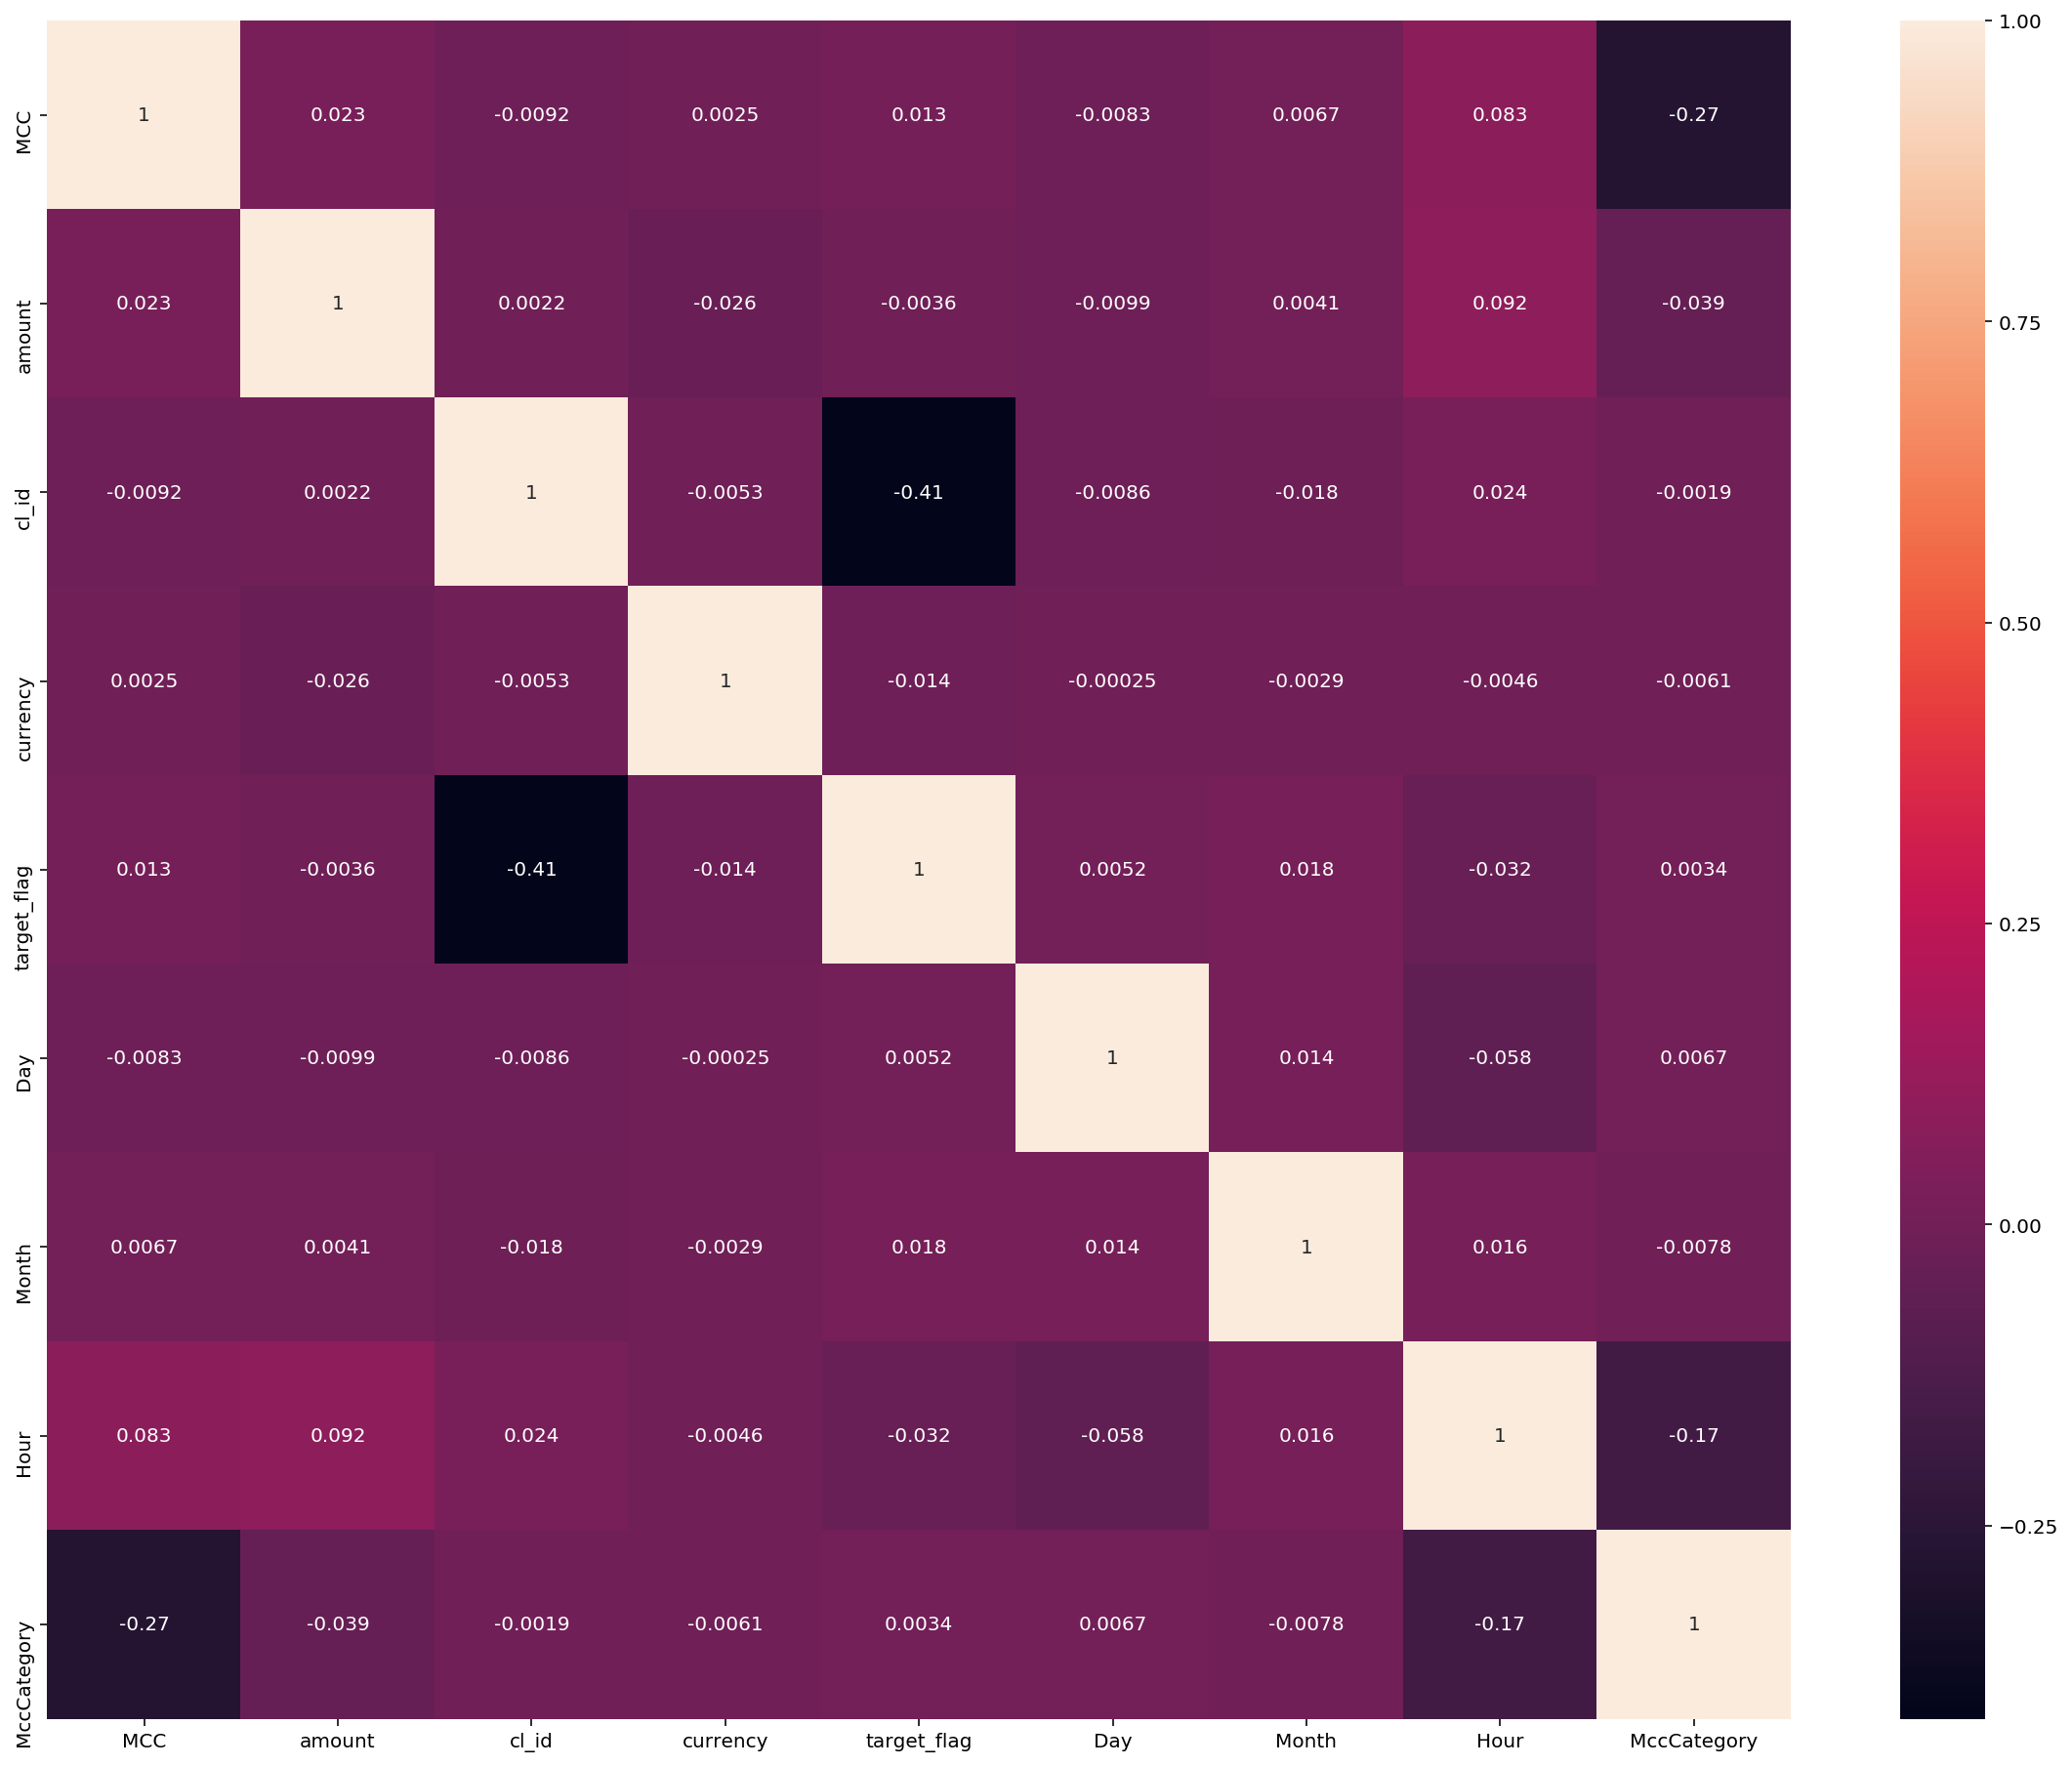

In [18]:
plt.figure(figsize=(20, 16))

corr = train_full_df.corr()
sns.heatmap(corr, annot=True, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

## Обработка данных

In [19]:
del train_full_df['CODE']
del train_full_df['TRDATETIME']


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

train_full_df_labeled = train_full_df.copy()
train_full_df_labeled['PERIOD']            = le.fit_transform(train_full_df_labeled['PERIOD'])
train_full_df_labeled['MCC']               = le.fit_transform(train_full_df_labeled['MCC'])
train_full_df_labeled['currency']          = le.fit_transform(train_full_df_labeled['currency'])
train_full_df_labeled['channel_type']      = le.fit_transform(train_full_df_labeled['channel_type'])
train_full_df_labeled['trx_category']      = le.fit_transform(train_full_df_labeled['trx_category'])
train_full_df_labeled['MccCategory']       = le.fit_transform(train_full_df_labeled['MccCategory'])
train_full_df_labeled['target_flag']       = le.fit_transform(train_full_df_labeled['target_flag'])
train_full_df_labeled['amount']            = le.fit_transform(train_full_df_labeled['amount'])
train_full_df_labeled['cl_id']             = le.fit_transform(train_full_df_labeled['cl_id'])


## Разделяем выборки

In [20]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

y = train_full_df_labeled['target_flag']
train_full_df_labeled.drop(columns='target_flag', inplace=True)

In [21]:

X_train, X_test, Y_train, Y_test = train_test_split(train_full_df_labeled[::200], y[::200], test_size=0.3)


In [22]:
#Шкалирование данных
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [23]:
X_train.shape

(3531, 12)

## Применение Lasso

In [24]:
lasso =  Lasso();
lasso.fit(X_train, Y_train);

In [25]:
print('R^2 is {}'.format(lasso.score(X_train, Y_train)))

R^2 is 0.0906248409693221


In [26]:
lasso.coef_

array([-4.92026424e+01, -1.18561185e+03,  4.17174806e-02,  1.87701588e+04,
       -1.42665721e+01,  7.67730194e+02,  2.26591139e+03,  9.45146536e+02,
       -2.76700524e+03, -3.04953454e+02, -6.22069234e+02,  4.69849174e+02])

In [27]:
lasso.intercept_

133764.05109359982

## Применение РСА

In [28]:
pca = PCA().fit(X_train,Y_train)

Text(0,0.5,'explained_variance_ratio')

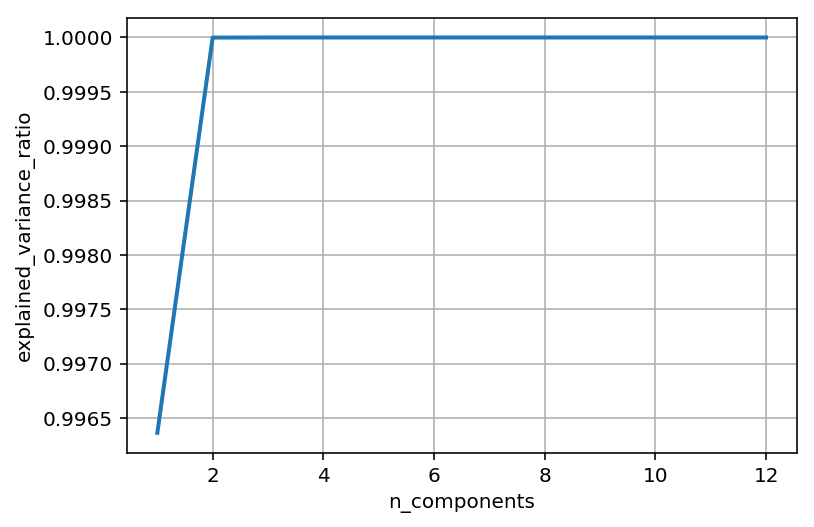

In [29]:
cum_evr = np.cumsum(pca.explained_variance_ratio_)
xs = np.arange(cum_evr.size) + 1
plt.plot(xs, cum_evr, linewidth=2)
plt.grid()
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio')

In [30]:
X_train_pca = pca.transform(X_train)
X_train_pca

array([[ 9.57174993e+03,  4.23487729e+03,  3.38200221e+01, ...,
        -1.67479570e-01,  2.79168314e-01, -2.79312069e-01],
       [-5.14935306e+04,  2.80371330e+03, -6.72320195e+01, ...,
         2.08812027e-01,  4.72012012e-02,  7.47343656e-01],
       [ 7.03116585e+04, -9.53894180e+02,  4.82245886e+01, ...,
        -7.42054834e-02, -5.83961184e-01,  7.55892346e-01],
       ...,
       [-7.11649070e+03, -1.67061296e+03,  2.53365627e+01, ...,
        -3.89746956e-02,  2.82482210e-01, -2.66799425e-01],
       [ 9.90548652e+04,  4.68405556e+03, -3.58151356e+01, ...,
         4.72939770e+00,  4.24642852e-01,  7.37056412e-01],
       [ 7.16230213e+03,  2.09238342e+03,  2.30492739e+01, ...,
        -3.57161814e-01, -5.87838064e-02, -2.56822916e-01]])

## Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

params = [ {'max_depth': list( range(1, 20) )} ]
gs = GridSearchCV( RandomForestClassifier(), param_grid = params, scoring = 'accuracy', return_train_score = False)
gs.fit(X_train_pca, Y_train )

C:\Users\Helen\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


In [32]:
gs.best_params_

{'max_depth': 7}

In [33]:
clf_etc = RandomForestClassifier(n_estimators=10, max_depth=7, min_samples_leaf=10, max_features=0.8, n_jobs=-1)
clf_etc.fit(X_train_pca, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features=0.8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [46]:
y_hat = clf_etc.predict(X_train_pca)
print("Accuracy score", accuracy_score(Y_train, y_hat))

Accuracy score 0.39932030586236195


## Logistic Regression

In [41]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_pca,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [45]:
y_hat = lr.predict(X_train_pca)
print("Accuracy score", accuracy_score(Y_train, y_hat))

Accuracy score 0.3372982158028887
